#BMatrices experiments#

##1. Import e definizioni di libreria##

In [524]:
import numpy as np
from scipy.sparse import dok_matrix
import matplotlib as mlp
from matplotlib import pyplot
%matplotlib inline
import random as rnd
import math
import gensim as gn
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [525]:
def draw(matrix):
    pyplot.figure(figsize = (2,2))
    try:
        pyplot.imshow(matrix,  interpolation ='nearest',cmap = 'gray')
    except:
        pyplot.imshow(matrix.todense(),  interpolation ='nearest',cmap = 'gray')
    pyplot.xlabel('words')
    pyplot.ylabel('')
    pyplot.axis('off')

def drawAll(vector_matrices, n_columns=4, verbose=False, size=None):
    k = 0
    n_matrices = len(vector_matrices)
    if n_matrices % n_columns == 0:
        n_rows = n_matrices / n_columns
    else:
        n_rows = int(n_matrices / n_columns)+1
        
    if verbose:
        print("n_rows", n_rows)
        print("n_columns", n_columns)
    if size is None:
        fig = pyplot.figure()
    else:
        fig = pyplot.figure(figsize = (size,size))
    
    for k in xrange(n_matrices):
        pyplot.subplot(n_rows,n_columns,k)
        try:
            pyplot.imshow(vector_matrices[k],  interpolation ='nearest',cmap = 'gray')
        except:
            pyplot.imshow(vector_matrices[k].todense(),  interpolation ='nearest',cmap = 'gray')
        if verbose:
            print(k)
        k += 1

In [526]:
def applyNoise(PROTOTYPE, p_noise):
    sample = np.array(PROTOTYPE.todense())
    for i in xrange(sample.shape[0]):
        for j in xrange(sample.shape[1]):
            noise = rnd.gauss(0, p_noise)
            if sample[i,j] == 0:
                sample[i,j] = math.fabs(noise)
            else:
                sample[i,j] = 1 - math.fabs(noise)
    return sample

In [527]:
def generateBrothers(PROTOTYPE, n, p_noise):
    brothers = applyNoise(PROTOTYPE, p_noise)
    for i in xrange(n-1):
        brothers = np.concatenate((brothers, applyNoise(PROTOTYPE, p_noise)), axis=0)
    return brothers

In [528]:
def generateDS(prototypes, n_examples, n_attributes, p_noise):
    table = np.empty((n_examples, n_attributes*n_attributes))
    labels = np.empty(n_examples)
    for i in xrange(n_examples):
        index_prototype = rnd.randint(0,len(prototypes)-1)
        PROTOTYPE = prototypes[index_prototype]
        table[i] = applyNoise(PROTOTYPE, p_noise).reshape((1, n_attributes*n_attributes))
        labels[i] = index_prototype 
    return {"table":table, "labels":labels}

In [529]:
def tryTransformations(dataset, seed=0, n_pca_components = None, n_lda_passes = 1, verbose=False):

    table = (100*dataset["table"]).astype(int)
    corpus = []
    for row in table:
        corpus.append(gn.matutils.any2sparse(np.array(row)))

    labels = dataset["labels"]
    n_attribs = table.shape[1]
    classes = set(labels)
    n_classes = len(classes)
    
    if verbose:
        print("n_attribs " + str(n_attribs))
        print("classes: " + str(classes))
        print("n_classes " + str(n_classes))

    scores = {}
    confusions = {}

    # BOW
    if verbose:
        print("BOW table:")
        print(table)

    X_train, X_test, y_train, y_test = train_test_split(table, labels, random_state=seed)
    classifier = svm.SVC()
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    scores["BOW"] = score
    confusions["BOW"] = cm
    


    # PCA
    table = PCA(n_pca_components).fit_transform(table)
    
    if verbose:
        print("PCA table:")
        print(table)

    X_train, X_test, y_train, y_test = train_test_split(table, labels, random_state=seed)
    classifier = svm.SVC()
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    scores["PCA"] = score
    confusions["PCA"] = cm


    # TFIDF
    tfidf = gn.models.TfidfModel(corpus)
    tfidf_corpus = tfidf[corpus]
    table = gn.matutils.corpus2dense(tfidf_corpus, n_attribs).T
    
    if verbose:
        print("TFIDF table:")
        print(table)

    X_train, X_test, y_train, y_test = train_test_split(table, labels, random_state=seed)
    classifier = svm.SVC()
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores["TFIDF"] = score
    confusions["TFIDF"] = cm

    # LSI
    lsi = gn.models.LsiModel(tfidf_corpus, num_topics=n_classes)
    lsi_corpus = lsi[tfidf_corpus]
    table = gn.matutils.corpus2dense(lsi_corpus, n_attribs).T
    table = table[:,:n_classes]
    
    if verbose:
        print("LSI table:")
        print(table)

    X_train, X_test, y_train, y_test = train_test_split(table, labels, random_state=seed)
    classifier = svm.SVC()
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    scores["LSI"] = score
    confusions["LSI"] = cm

    # LDA
    lda = gn.models.LdaModel(tfidf_corpus, num_topics=n_classes, passes=n_lda_passes)
    lda_corpus = lda[tfidf_corpus]
    table = gn.matutils.corpus2dense(lda_corpus, n_attribs).T
    table = table[:,:n_classes]
    
    if verbose:
        print("LDA table:")
        print(table)

    X_train, X_test, y_train, y_test = train_test_split(table, labels, random_state=seed)
    classifier = svm.SVC()
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    scores["LDA"] = score
    confusions["LDA"] = cm
    

    return {"scores": scores, "confusions": confusions}


##2. Modellazione##

Definizione dei parametri dell'esperimento

In [544]:
rnd.seed = 0
n_examples = 300
n_attributes = 30
fattore_rumore = 0

Generazione dei prototipi di classe

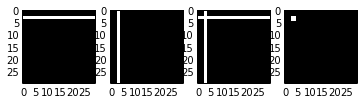

In [545]:
PROTOTYPE_0 = dok_matrix((n_attributes, n_attributes), dtype=np.float32)
PROTOTYPE_0[3, 3] = 1
PROTOTYPE_0[3, 4] = 1
PROTOTYPE_0[4, 3] = 1
PROTOTYPE_0[4, 4] = 1
PROTOTYPE_1 = dok_matrix((n_attributes, n_attributes), dtype=np.float32)
for i in xrange(n_attributes):
    PROTOTYPE_1[3, i] = 1
PROTOTYPE_2 = dok_matrix((n_attributes, n_attributes), dtype=np.float32)
for i in xrange(n_attributes):
    PROTOTYPE_2[i, 3] = 1
PROTOTYPE_3 = dok_matrix((n_attributes, n_attributes), dtype=np.float32)
for i in xrange(n_attributes):
    PROTOTYPE_3[i, 3] = 1
    PROTOTYPE_3[3, i] = 1

prototypes = [PROTOTYPE_0, PROTOTYPE_1, PROTOTYPE_2, PROTOTYPE_3]
drawAll(prototypes)



Esempio di aggiunta rumore

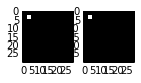

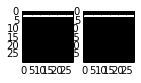

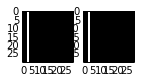

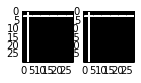

In [546]:
#sample = applyNoise(PROTOTYPE_0, fattore_rumore)
#print(PROTOTYPE_0.todense())
#print(a)
for proto in prototypes:
    sample = applyNoise(proto, fattore_rumore)
    drawAll([sample, proto], n_columns = 2, size = 2)

In [547]:
DS = generateDS(prototypes, n_examples, n_attributes, fattore_rumore)


In [548]:
experiment = tryTransformations(DS, verbose=False, n_pca_components=3, n_lda_passes=1)

In [549]:
pprint(experiment["scores"])

{'BOW': 1.0,
 'LDA': 0.7466666666666667,
 'LSI': 1.0,
 'PCA': 1.0,
 'TFIDF': 0.26666666666666666}


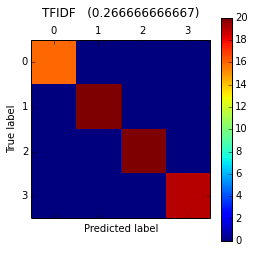

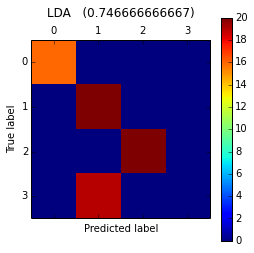

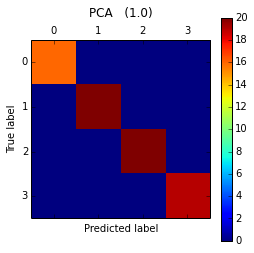

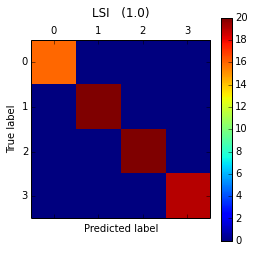

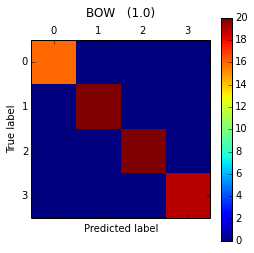

In [550]:
for t in experiment["confusions"]:
    #pprint(t)
    #pprint(experiment["confusions"][t])
    pyplot.matshow(experiment["confusions"][t])
    title = t + "   (" + str(experiment["scores"][t]) + ")"
    pyplot.title(title, y =1.1)
    pyplot.colorbar()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    
pyplot.show()